## Import Modules

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Load the Dataset

In [2]:
train_set = r'E:\cloud_learning\BE_project\train\train'
test_set = r'E:\cloud_learning\BE_project\test\test'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for filename in os.listdir(label_path):
            image_paths.append(os.path.join(label_path, filename))
            labels.append(label)
        print(label, "completed")
    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_set)
train = train.sample(frac=1).reset_index(drop=True)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_set)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [6]:
# Label encoding
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
test['label'] = le.transform(test['label'])

In [7]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']
        image = Image.open(image_path).convert('L').resize((48, 48))
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
train_ds = ImageDataset(train, transform=transform)
test_ds = ImageDataset(test, transform=transform)

In [10]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128)

## Model Training

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=7).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [14]:
train_losses, test_losses, train_accs, test_accs = [], [], [], []

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, train_accs, test_accs = [], [], [], []

for epoch in range(100):  
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accs.append(correct / total)
    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    model.eval()
    correct, total, loss_eval = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_eval += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_accs.append(correct / total)
    test_losses.append(loss_eval / len(test_loader))

    print(f"Epoch {epoch+1}: Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

Epoch 1: Train Acc: 0.4806, Test Acc: 0.5121
Epoch 2: Train Acc: 0.4885, Test Acc: 0.5079
Epoch 3: Train Acc: 0.4961, Test Acc: 0.5340
Epoch 4: Train Acc: 0.5024, Test Acc: 0.5390
Epoch 5: Train Acc: 0.5105, Test Acc: 0.5482
Epoch 6: Train Acc: 0.5159, Test Acc: 0.5500
Epoch 7: Train Acc: 0.5256, Test Acc: 0.5447
Epoch 8: Train Acc: 0.5296, Test Acc: 0.5571
Epoch 9: Train Acc: 0.5314, Test Acc: 0.5593
Epoch 10: Train Acc: 0.5410, Test Acc: 0.5556
Epoch 11: Train Acc: 0.5407, Test Acc: 0.5623
Epoch 12: Train Acc: 0.5489, Test Acc: 0.5758
Epoch 13: Train Acc: 0.5493, Test Acc: 0.5717
Epoch 14: Train Acc: 0.5536, Test Acc: 0.5676
Epoch 15: Train Acc: 0.5646, Test Acc: 0.5770
Epoch 16: Train Acc: 0.5609, Test Acc: 0.5830
Epoch 17: Train Acc: 0.5641, Test Acc: 0.5855
Epoch 18: Train Acc: 0.5648, Test Acc: 0.5861
Epoch 19: Train Acc: 0.5679, Test Acc: 0.5837
Epoch 20: Train Acc: 0.5715, Test Acc: 0.5868
Epoch 21: Train Acc: 0.5748, Test Acc: 0.5811
Epoch 22: Train Acc: 0.5771, Test Acc: 0.58

## Accuracy Plot

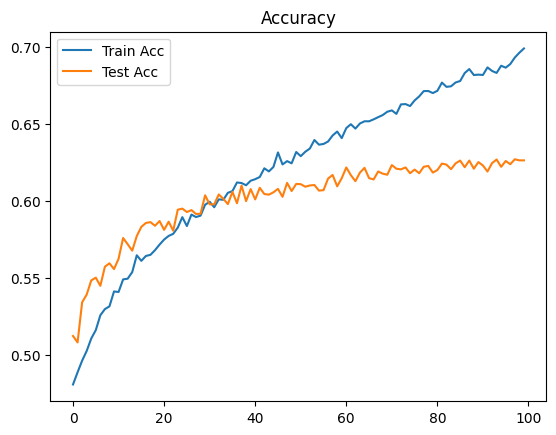

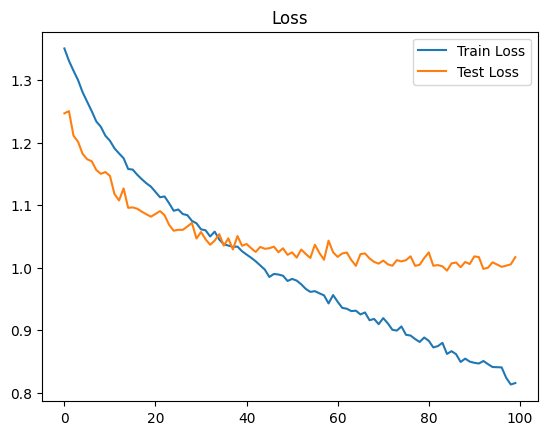

In [25]:
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Test with image data

Original label: happy
Predicted label: happy


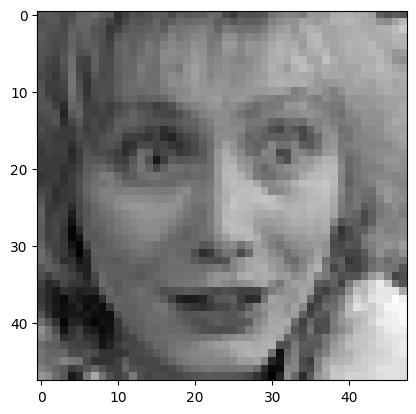

In [27]:
index = random.randint(0, len(test_ds)-1)
image, label = test_ds[index]
image_tensor = image.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    pred = model(image_tensor)
    pred_label = pred.argmax(dim=1).item()
print("Original label:", le.inverse_transform([label])[0])
print("Predicted label:", le.inverse_transform([pred_label])[0])
plt.imshow(image.squeeze().cpu(), cmap='gray')
plt.show()